# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
import time
from scipy.interpolate import PchipInterpolator
import scipy
from collections import defaultdict

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from itertools import chain

# Data (Tension)

## Original

In [2]:
df = pd.read_csv("../files/data/Corner_Crack_BH_QE/SUBSET-SINGLE.csv", index_col=False)
df = df.drop(columns=["b/t"])
df

,W/R,a/c,a/t,r/t,phi,K-T,K-B,K-P
0,2.2,0.1,0.10,1.25,0.00006,0.8162,0.9663,0.7523
1,2.2,0.1,0.10,1.25,0.00012,0.8409,0.9954,0.7750
2,2.2,0.1,0.10,1.25,0.00018,0.8549,1.0120,0.7880
3,2.2,0.1,0.10,1.25,0.00024,0.8646,1.0240,0.7970
4,2.2,0.1,0.10,1.25,0.00030,0.8720,1.0320,0.8037
...,...,...,...,...,...,...,...,...
5515345,100.0,10.0,0.95,1.00,1.57056,1.9370,-1.1080,48.6900
5515346,100.0,10.0,0.95,1.00,1.57062,1.9150,-1.0960,48.1300
5515347,100.0,10.0,0.95,1.00,1.57068,1.8820,-1.0770,47.3100
5515348,100.0,10.0,0.95,1.00,1.57074,1.8360,-1.0510,46.1500


In [3]:
# Get unique combinations of the first four columns
CC_combinations = df.iloc[:, :4].drop_duplicates().to_numpy()

print(len(CC_combinations))

24524


In [4]:
print("Different W/r values: ", np.unique(CC_combinations[:,0], axis=0))
print("Different a/c values: ", np.unique(CC_combinations[:,1], axis=0))
print("Different a/t values: ", np.unique(CC_combinations[:,2], axis=0))
print("Different r/t values: ", np.unique(CC_combinations[:,3], axis=0))

Different W/r values:  [  1.6   1.8   2.    2.2   2.4   2.8   3.2   3.6   4.    4.6   5.2   5.8
   6.4   7.    8.   10.   12.   15.   66.7  80.  100.  125.  149.9 175.
 200. ]
Different a/c values:  [ 0.1     0.111   0.125   0.1428  0.1667  0.2     0.25    0.333   0.5
  0.667   0.75    0.8     1.      1.25    1.333   1.5     2.      3.
  4.      5.      6.      7.      8.      9.     10.    ]
Different a/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [0.5    0.5714 0.667  0.8    1.     1.25   1.5   ]


In [7]:
d = df.to_numpy()

# Build a mapping from combination to indices
comb_to_indices = defaultdict(list)
for idx, row in enumerate(d):
    comb = tuple(row[:4])
    comb_to_indices[comb].append(idx)

# Convert lists to numpy arrays for faster indexing
for comb in comb_to_indices:
    comb_to_indices[comb] = np.array(comb_to_indices[comb])

CC_phi_regular_64 = np.linspace(0.052, 1.52, 64)
CC_K_regular_64 = np.zeros((len(CC_combinations), len(CC_phi_regular_64)))

for i, combination in enumerate(CC_combinations):
    comb_tuple = tuple(combination)
    indices = comb_to_indices.get(comb_tuple, np.array([]))
    if indices.size == 0:
        continue  # No data for this combination

    phi_vals = d[indices][:, 4]
    K_vals = d[indices][:, 5]

    phi_min = phi_vals.min() + 0.035
    phi_max = phi_vals.max() - 0.035

    # Filter indices where phi values lie within [phi_min, phi_max]
    filtered_indices = indices[(phi_vals >= phi_min) & (phi_vals <= phi_max)]

    phi_vals = d[filtered_indices][:,4]
    K_vals = d[filtered_indices][:,5]
    phi_idxes = np.argsort(phi_vals)
    
    monotonic_phi_idxes = [phi_idxes[0]]
    prev_phi = phi_vals[phi_idxes[0]]
    for index in phi_idxes[1:]:
        now_phi = phi_vals[index]
        if now_phi > prev_phi:
            monotonic_phi_idxes.append(index)
            prev_phi = phi_vals[index]
    
    interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)

    CC_K_regular_64[i,:] = interp_func(CC_phi_regular_64)

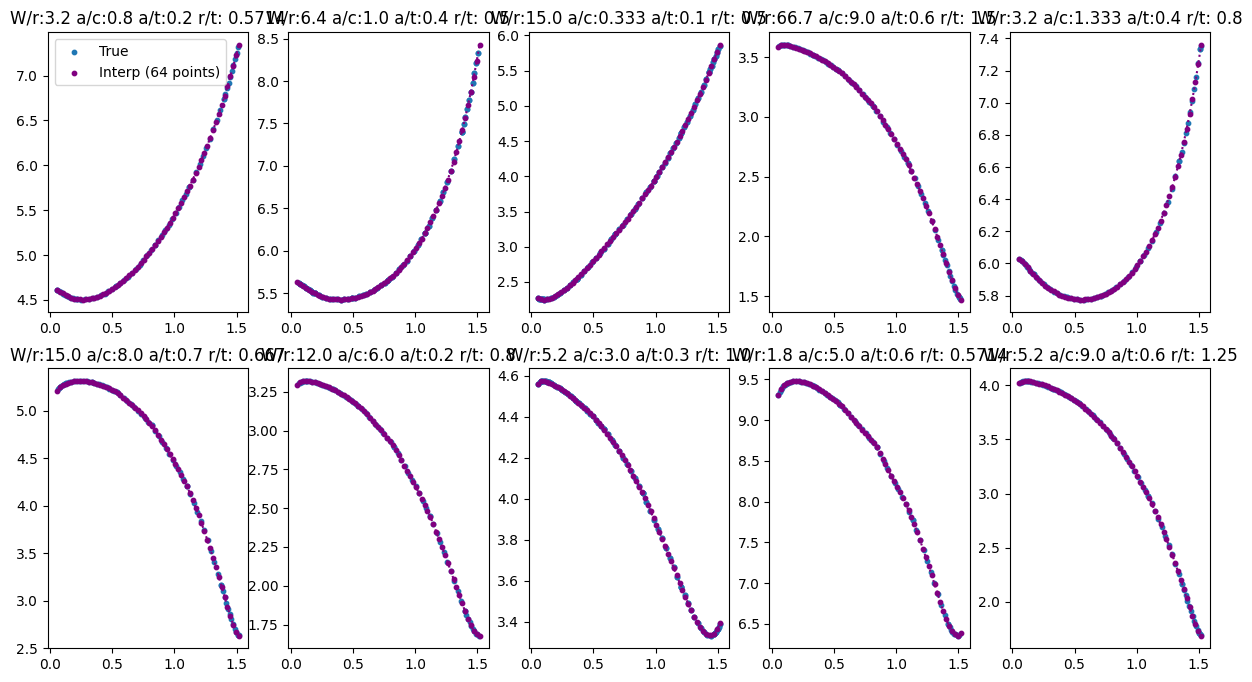

In [17]:
# np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(15,8))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(CC_combinations))
        combination = CC_combinations[idx]
        indices = np.where((d[:, 0] == combination[0]) & 
                        (d[:, 1] == combination[1]) &
                        (d[:, 2] == combination[2]) &
                        (d[:, 3] == combination[3]) &
                        (d[:, 4] >= 0.052) & 
                        (d[:, 4] <= 1.52))
        indices = indices[0]
        axs[i,j].scatter(d[indices][:,4], d[indices][:,5], label="True", s=10)
        axs[i,j].scatter(CC_phi_regular_64, CC_K_regular_64[idx], label="Interp (64 points)", color='purple', s=10)
        axs[i,j].plot(CC_phi_regular_64, CC_K_regular_64[idx], color='purple', linestyle=":")
        axs[i,j].set_title("W/r:{} a/c:{} a/t:{} r/t: {}".format(combination[0], combination[1], combination[2], combination[3]))
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

## New

In [20]:
df = pd.read_csv("../files/data/Corner_Crack_BH_QE/CASE24_KI_Single_Cracks.csv", index_col=False)
df = df[df['a/t'] < 1]
df = df.drop(columns=["b/t"])
df

,W/R,a/c,a/t,r/t,phi,K-T,K-B,K-P
0,200.000,0.1,0.10,0.50,0.00006,0.9527,0.979,4.655
1,200.000,0.1,0.10,0.50,0.00012,0.9788,1.006,4.782
2,200.000,0.1,0.10,0.50,0.00018,0.9972,1.025,4.873
3,200.000,0.1,0.10,0.50,0.00024,1.0100,1.038,4.934
4,200.000,0.1,0.10,0.50,0.00030,1.0180,1.046,4.974
...,...,...,...,...,...,...,...,...
4306854,133.333,10.0,0.95,0.75,1.57056,2.2050,-1.321,73.200
4306855,133.333,10.0,0.95,0.75,1.57062,2.1800,-1.306,72.370
4306856,133.333,10.0,0.95,0.75,1.57068,2.1430,-1.284,71.140
4306857,133.333,10.0,0.95,0.75,1.57074,2.0900,-1.252,69.390


In [21]:
# Get unique combinations of the first four columns
CC_combinations_ = df.iloc[:, :4].drop_duplicates().to_numpy()

print(len(CC_combinations_))

5000


In [22]:
print("Different W/r values: ", np.unique(CC_combinations_[:,0], axis=0))
print("Different a/c values: ", np.unique(CC_combinations_[:,1], axis=0))
print("Different a/t values: ", np.unique(CC_combinations_[:,2], axis=0))
print("Different r/t values: ", np.unique(CC_combinations_[:,3], axis=0))

Different W/r values:  [  10.      12.5     20.      25.      33.333   40.      50.      57.143
   75.019   80.     125.     133.333  175.009  200.     300.3    500.
  700.28   800.     900.901 1000.   ]
Different a/c values:  [ 0.1     0.111   0.125   0.1428  0.1667  0.2     0.25    0.333   0.5
  0.667   0.75    0.8     1.      1.25    1.333   1.5     2.      3.
  4.      5.      6.      7.      8.      9.     10.    ]
Different a/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [ 0.1     0.111   0.125   0.1428  0.2     0.333   0.5     0.5714  0.75
  0.8     1.25    1.333   1.75    2.      2.5     3.      4.      5.
  8.     10.    ]


In [23]:
d = df.to_numpy()

# Build a mapping from combination to indices
comb_to_indices = defaultdict(list)
for idx, row in enumerate(d):
    comb = tuple(row[:4])
    comb_to_indices[comb].append(idx)

# Convert lists to numpy arrays for faster indexing
for comb in comb_to_indices:
    comb_to_indices[comb] = np.array(comb_to_indices[comb])

CC_phi_regular_64 = np.linspace(0.052, 1.52, 64)
CC_K_regular_64_ = np.zeros((len(CC_combinations_), len(CC_phi_regular_64)))

for i, combination in enumerate(CC_combinations_):
    comb_tuple = tuple(combination)
    indices = comb_to_indices.get(comb_tuple, np.array([]))
    if indices.size == 0:
        continue  # No data for this combination

    phi_vals = d[indices][:, 4]
    K_vals = d[indices][:, 5]

    phi_min = phi_vals.min() + 0.035
    phi_max = phi_vals.max() - 0.035

    # Filter indices where phi values lie within [phi_min, phi_max]
    filtered_indices = indices[(phi_vals >= phi_min) & (phi_vals <= phi_max)]

    phi_vals = d[filtered_indices][:,4]
    K_vals = d[filtered_indices][:,5]
    phi_idxes = np.argsort(phi_vals)
    
    monotonic_phi_idxes = [phi_idxes[0]]
    prev_phi = phi_vals[phi_idxes[0]]
    for index in phi_idxes[1:]:
        now_phi = phi_vals[index]
        if now_phi > prev_phi:
            monotonic_phi_idxes.append(index)
            prev_phi = phi_vals[index]
    
    interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)

    CC_K_regular_64_[i,:] = interp_func(CC_phi_regular_64)

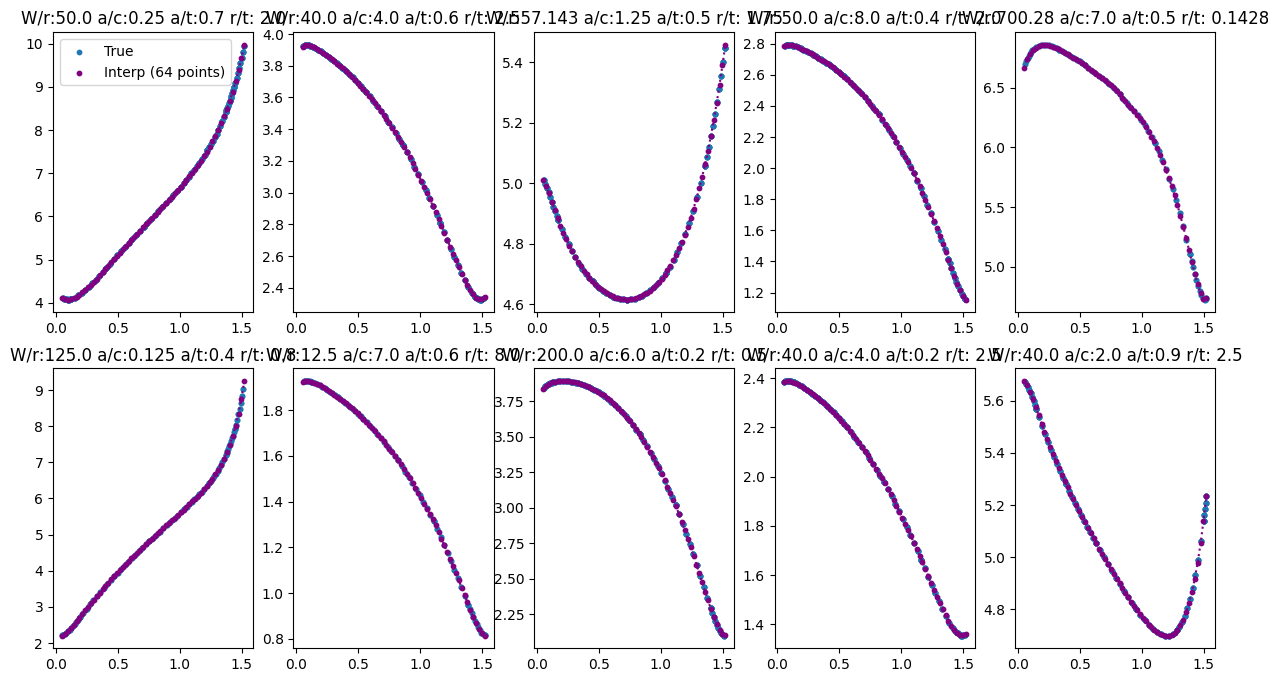

In [29]:
# np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(15,8))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(CC_combinations_))
        combination = CC_combinations_[idx]
        indices = np.where((d[:, 0] == combination[0]) & 
                        (d[:, 1] == combination[1]) &
                        (d[:, 2] == combination[2]) &
                        (d[:, 3] == combination[3]) &
                        (d[:, 4] >= 0.052) & 
                        (d[:, 4] <= 1.52))
        indices = indices[0]
        axs[i,j].scatter(d[indices][:,4], d[indices][:,5], label="True", s=10)
        axs[i,j].scatter(CC_phi_regular_64, CC_K_regular_64_[idx], label="Interp (64 points)", color='purple', s=10)
        axs[i,j].plot(CC_phi_regular_64, CC_K_regular_64_[idx], color='purple', linestyle=":")
        axs[i,j].set_title("W/r:{} a/c:{} a/t:{} r/t: {}".format(combination[0], combination[1], combination[2], combination[3]))
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

In [37]:
# Convert rows to tuples
A_tuples = set(map(tuple, CC_combinations_))
B_tuples = set(map(tuple, CC_combinations))

# Rows in CC_combinations_ that are in CC_combinations
A_in_B = np.array([row for row in CC_combinations_ if tuple(row) in B_tuples])

# Rows in CC_combinations_ that are NOT in CC_combinations
A_not_in_B = np.array([row for row in CC_combinations_ if tuple(row) not in B_tuples])

print("Rows in CC_combinations_ and in CC_combinations:", A_in_B.shape)
print("Rows in CC_combinations_ and NOT in CC_combinations:", A_not_in_B.shape)

Rows in CC_combinations_ and in CC_combinations: (743, 4)
Rows in CC_combinations_ and NOT in CC_combinations: (4257, 4)


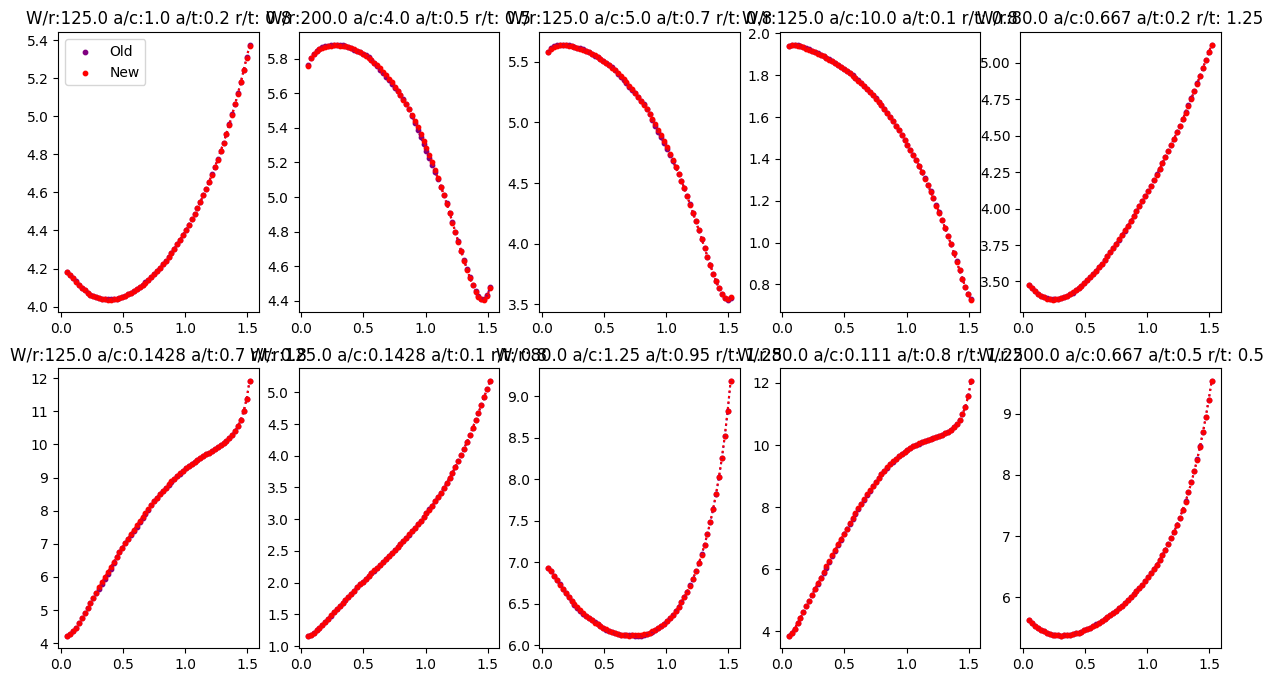

In [50]:
# np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(15,8))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(A_in_B))
        combination = A_in_B[idx]

        matches = np.all(CC_combinations == combination, axis=1)
        # Get the index (if any)
        matching_indices = np.where(matches)[0][0]
        axs[i,j].scatter(CC_phi_regular_64, CC_K_regular_64[matching_indices], label="Old", color='purple', s=10)
        axs[i,j].plot(CC_phi_regular_64, CC_K_regular_64[matching_indices], color='purple', linestyle=":")

        matches = np.all(CC_combinations_ == combination, axis=1)
        # Get the index (if any)
        matching_indices = np.where(matches)[0][0]
        axs[i,j].scatter(CC_phi_regular_64, CC_K_regular_64_[matching_indices], label="New", color='red', s=10)
        axs[i,j].plot(CC_phi_regular_64, CC_K_regular_64_[matching_indices], color='red', linestyle=":")


        axs[i,j].set_title("W/r:{} a/c:{} a/t:{} r/t: {}".format(combination[0], combination[1], combination[2], combination[3]))
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

In [47]:
# np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(15,8))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(A_in_B))
        combination = A_in_B[idx]

        matches = np.all(CC_combinations == combination, axis=1)
        # Get the index (if any)
        matching_indices = np.where(matches)[0][0]
        axs[i,j].scatter(CC_phi_regular_64, CC_K_regular_64[matching_indices], label="Old", color='purple', s=10)
        axs[i,j].plot(CC_phi_regular_64, CC_K_regular_64[matching_indices], color='purple', linestyle=":")

        matches = np.all(CC_combinations_ == combination, axis=1)
        # Get the index (if any)
        matching_indices = np.where(matches)[0][0]
        axs[i,j].scatter(CC_phi_regular_64, CC_K_regular_64_[matching_indices], label="New", color='red', s=10)
        axs[i,j].plot(CC_phi_regular_64, CC_K_regular_64_[matching_indices], color='red', linestyle=":")


        axs[i,j].set_title("W/r:{} a/c:{} a/t:{} r/t: {}".format(combination[0], combination[1], combination[2], combination[3]))
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

np.int64(10814)

In [40]:
CC_combinations

array([[2.20e+00, 1.00e-01, 1.00e-01, 1.25e+00],
       [2.40e+00, 1.00e-01, 1.00e-01, 1.25e+00],
       [2.80e+00, 1.00e-01, 1.00e-01, 1.25e+00],
       ...,
       [2.00e+02, 6.00e+00, 1.00e-01, 5.00e-01],
       [2.00e+02, 7.00e+00, 2.00e-01, 5.00e-01],
       [2.00e+02, 1.00e+01, 1.00e-01, 5.00e-01]], shape=(24524, 4))

In [41]:
A_in_B[0]

array([2.e+02, 1.e-01, 1.e-01, 5.e-01])